# aixtra Experimentation Notebook

In [277]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
import itertools
import re
import uuid
import json

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [278]:
class UUIDEncoder(json.JSONEncoder):
  def default(self, obj):
    if isinstance(obj, uuid.UUID):
      # if the obj is uuid, we simply return the value of uuid
      return str(obj)
    return json.JSONEncoder.default(self, obj)

In [279]:
def levenshteinDistanceDP(token1, token2):
  distances = np.zeros((len(token1) + 1, len(token2) + 1))

  for t1 in range(len(token1) + 1):
    distances[t1][0] = t1

  for t2 in range(len(token2) + 1):
    distances[0][t2] = t2
      
  a = 0
  b = 0
  c = 0
  
  for t1 in range(1, len(token1) + 1):
    for t2 in range(1, len(token2) + 1):
      if (token1[t1-1] == token2[t2-1]):
        distances[t1][t2] = distances[t1 - 1][t2 - 1]
      else:
        a = distances[t1][t2 - 1]
        b = distances[t1 - 1][t2]
        c = distances[t1 - 1][t2 - 1]
        
        if (a <= b and a <= c):
          distances[t1][t2] = a + 1
        elif (b <= a and b <= c):
          distances[t1][t2] = b + 1
        else:
          distances[t1][t2] = c + 1

  return distances[len(token1)][len(token2)]

## Load and show images

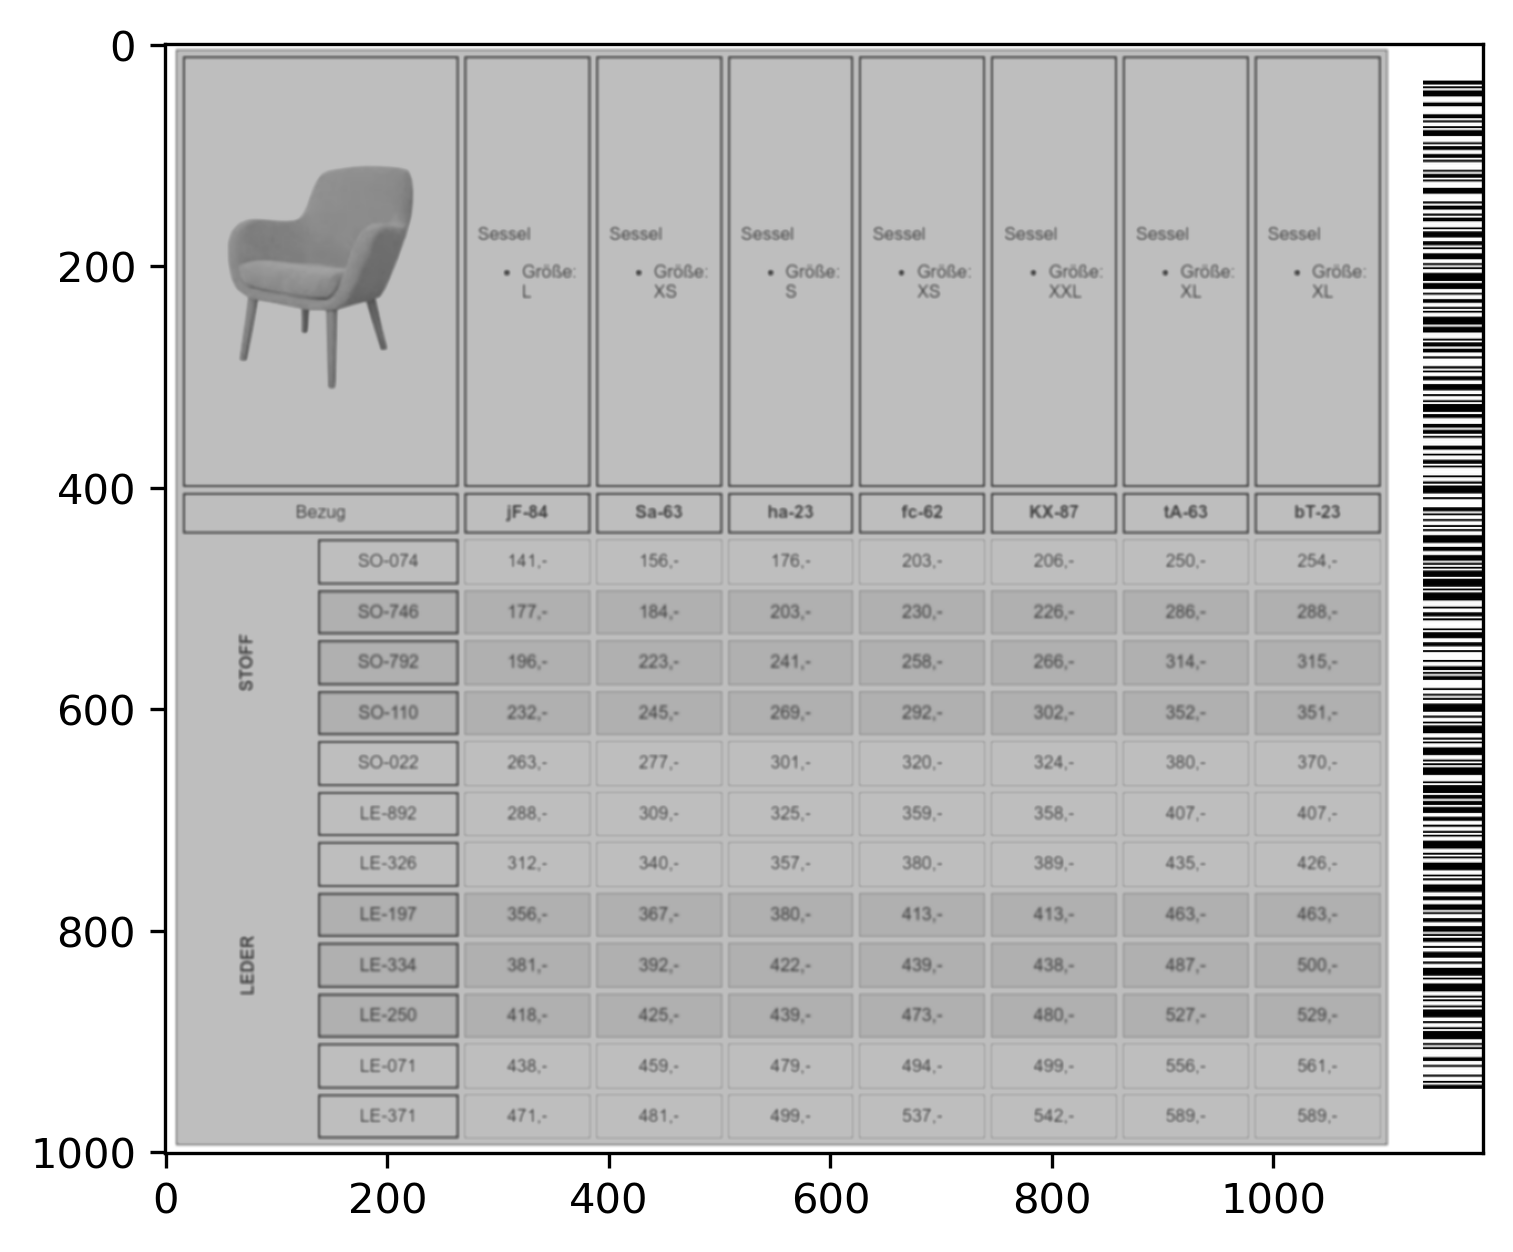

1190 1001


In [280]:
def show_image(opencv_img):
  rgb_im = cv2.cvtColor(opencv_img, cv2.COLOR_BGR2RGB)
  plt.imshow(rgb_im)
  plt.show()

image = cv2.imread("./images/image1.png", cv2.IMREAD_GRAYSCALE)

# Cut off some pixels from top and right
image = image[340:-413,:-50]
show_image(image)

height, width = image.shape
print(width, height)

## Image processing

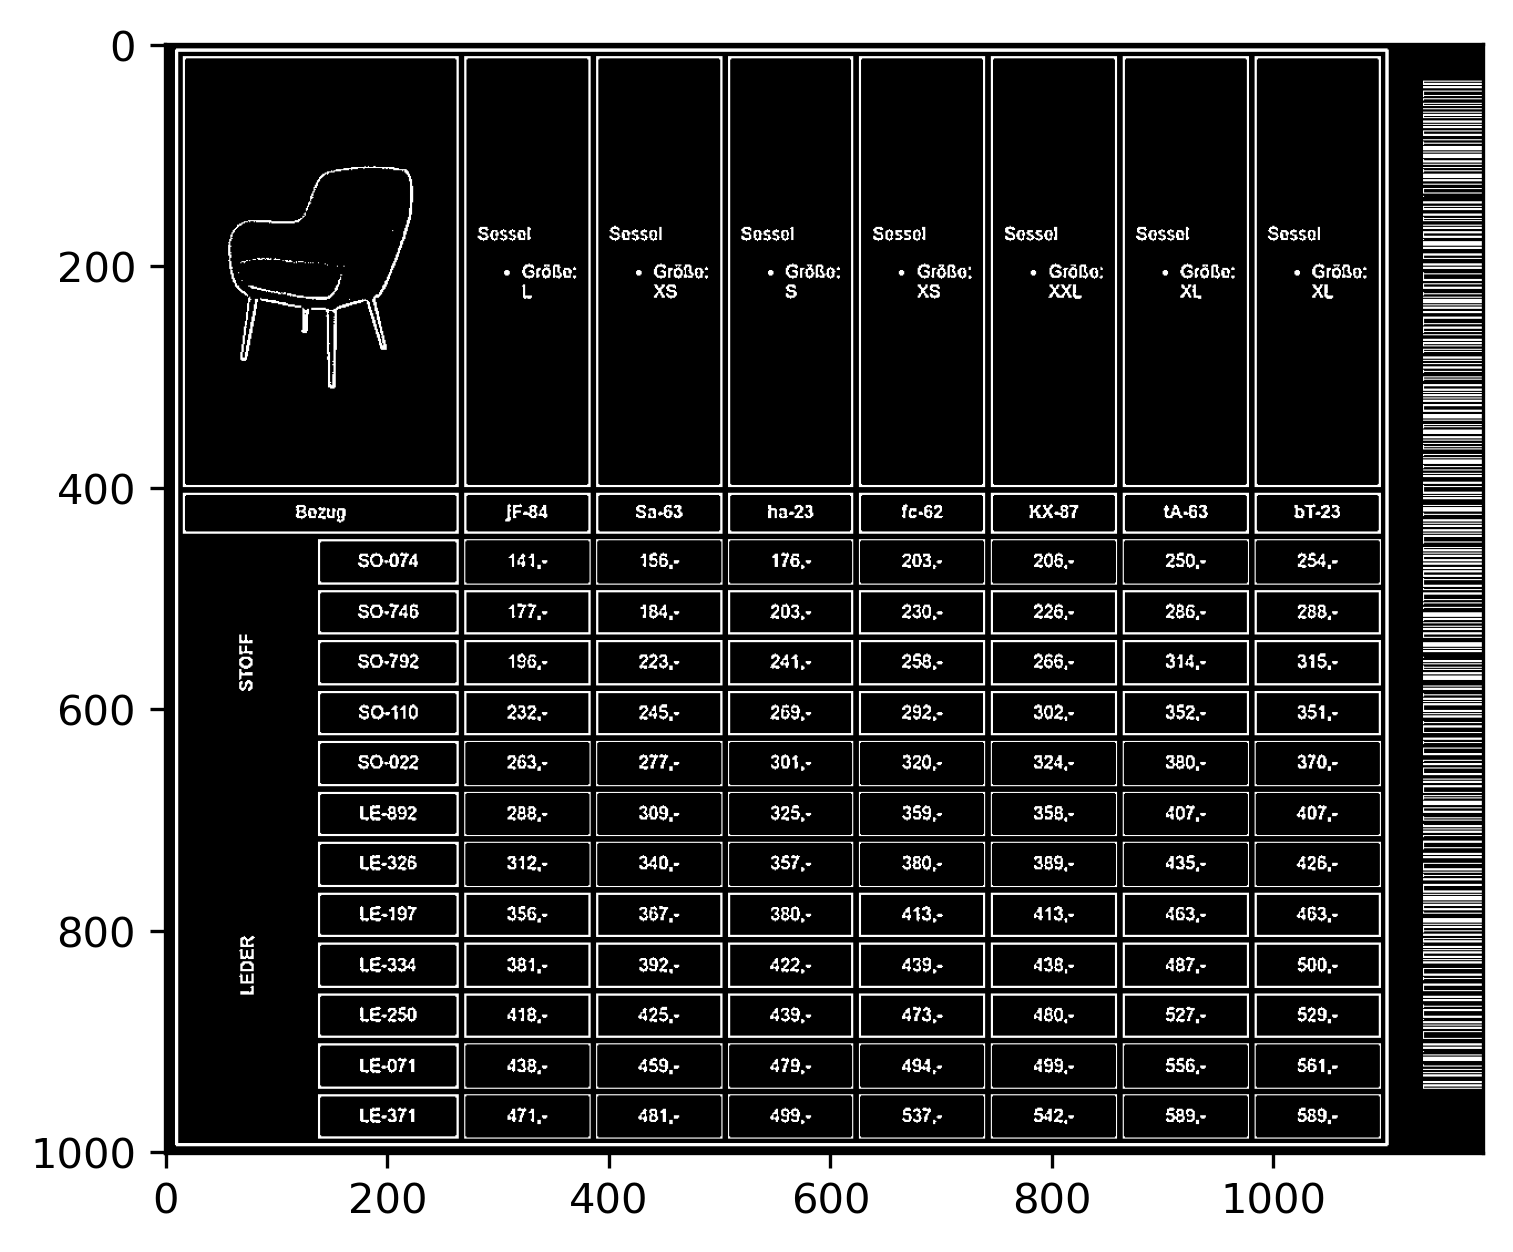

In [281]:
# Make image grayscale
thresholded = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3, 2)
thresholded_inv = 255-thresholded

plt.imshow(thresholded_inv,cmap='gray')
plt.show()

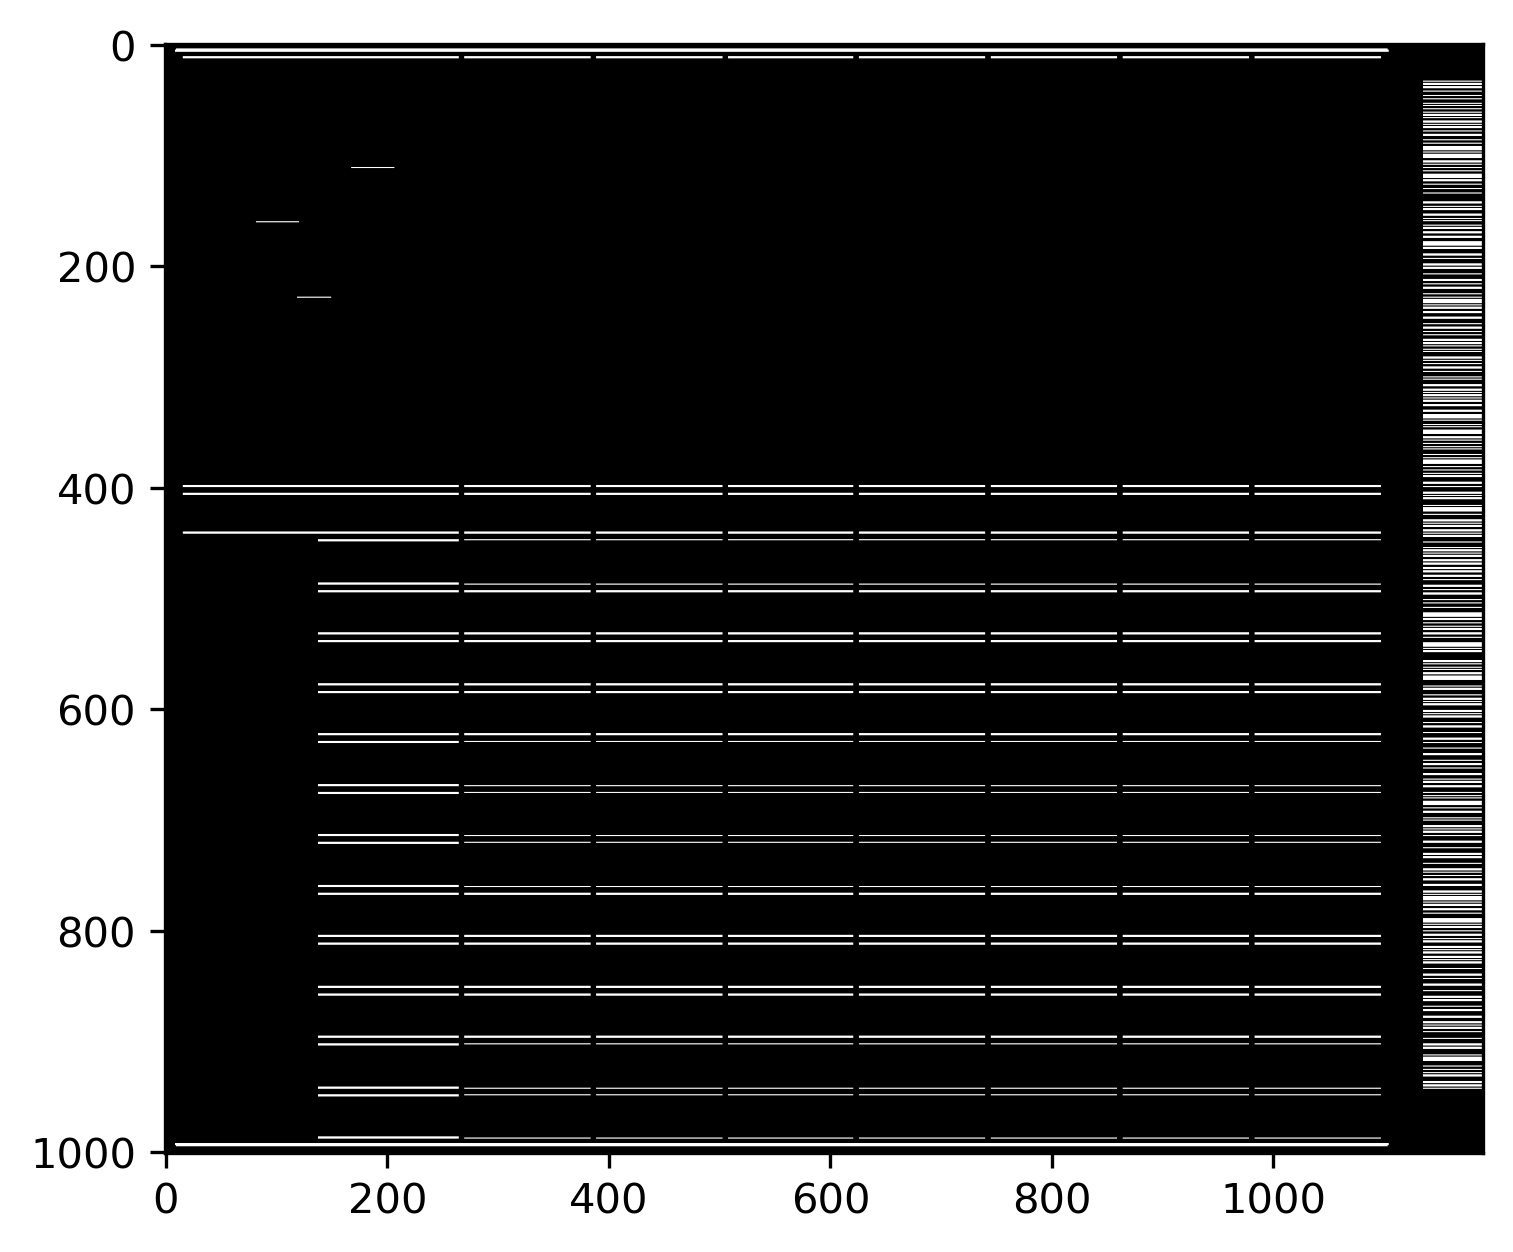

In [282]:
# Detect horizontal

length = np.array(image).shape[1]//100

horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (length, 1))
horizontal_detect = cv2.erode(thresholded_inv, horizontal_kernel, iterations=3)
hor_lines = cv2.dilate(horizontal_detect, horizontal_kernel, iterations=3)

plt.imshow(hor_lines,cmap='gray')
plt.show()

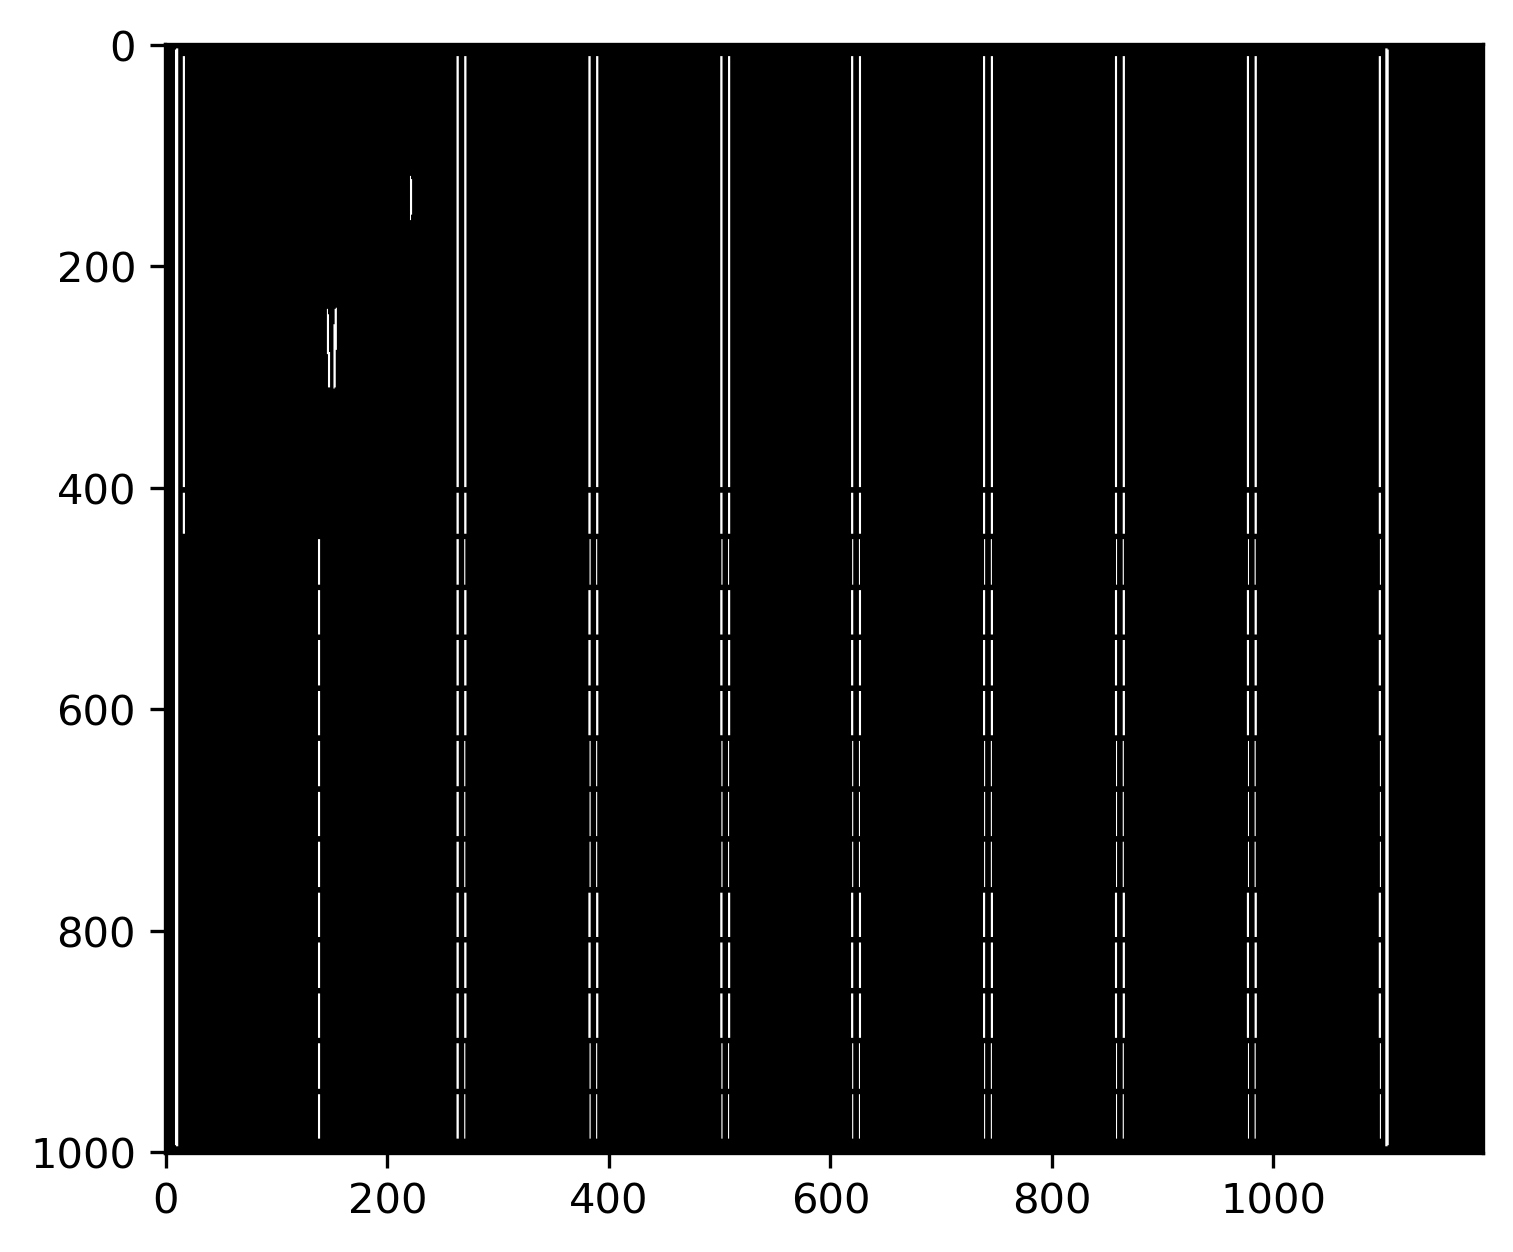

In [283]:
# Detect vertical

vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, length))
vertical_detect = cv2.erode(thresholded_inv, vertical_kernel, iterations=3)
ver_lines = cv2.dilate(vertical_detect, vertical_kernel, iterations=3)

plt.imshow(ver_lines,cmap='gray')
plt.show()

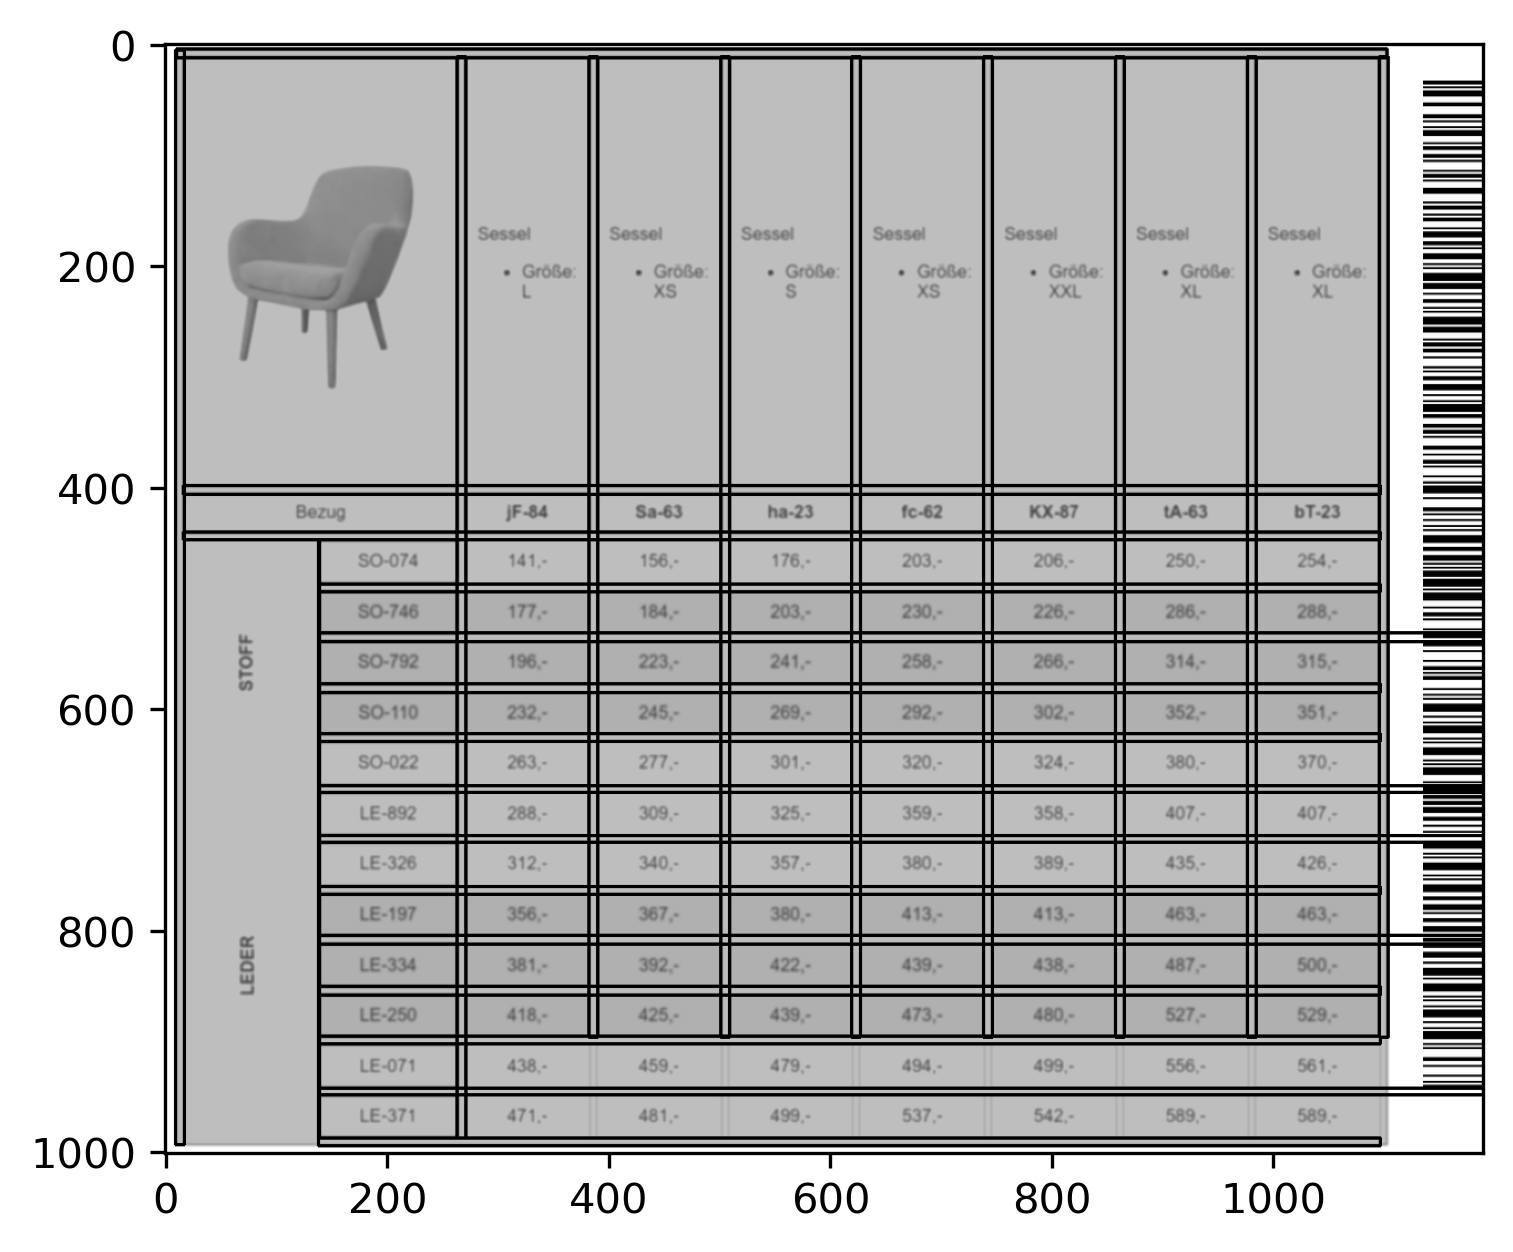

In [284]:
def find_long_horizontal_lines(hor_lines):
  # Find long horizontal lines that. They belong to our table.
  height, width = hor_lines.shape

  # Each entry is [row_start, row_end, col_start, col_end]
  hor_table_lines = []

  # We look for long lines in each row
  for row in range(height):
    line_pixels = 0
    line_start = None
    line_end = None

    for column in range(width):
      if hor_lines[row,column]:
        line_pixels += 1

        if not line_start:
          line_start = column

        line_end = column

    if line_pixels > 200 and line_start < width / 2:
      hor_table_lines.append([row, row, line_start, line_end])

  # Merge adjacent lines
  i = 0
  while i < len(hor_table_lines) - 1:
    curr = hor_table_lines[i]
    next = hor_table_lines[i + 1]

    if next[0] - curr[0] < 20:
      curr[1] = next[1]
      hor_table_lines.remove(next)
    else:
      i += 1

  return hor_table_lines


hor_table_lines = find_long_horizontal_lines(hor_lines)
ver_table_lines = [[*line[2:], *line[:2]] for line in find_long_horizontal_lines(ver_lines.T)]

# Output the found lines
temp_img = image.copy()
for line in [*hor_table_lines, *ver_table_lines]:
  cv2.rectangle(temp_img, (line[2], line[0]), (line[3], line[1]), 0, 2)
show_image(temp_img)

In [285]:
def get_row(index):
  """
  Return the start_y and end_y of the row with this index
  """
  return hor_table_lines[index][1] + 1, hor_table_lines[index + 1][0]

def get_column(index):
  """
  Return the start_x and end_x of the column with this index
  """
  return ver_table_lines[index][3] + 1, ver_table_lines[index + 1][2]

column_count = len(ver_table_lines) - 1
row_count = len(hor_table_lines) - 1

print([line[2] for line in ver_table_lines])
print([line[0] for line in hor_table_lines])

print(column_count)
print(row_count)

[9, 138, 263, 382, 501, 619, 738, 857, 976, 1095]
[4, 398, 440, 487, 531, 577, 622, 669, 714, 760, 804, 850, 895, 942, 987]
9
14


In [286]:
def parse_cell(row_start, column_start, row_end=None, column_end=None, rotate=False):
  start_y, end_y = get_row(row_start)
  start_x, end_x = get_column(column_start)

  if row_end:
    end_y = get_row(row_end)[1]

  if column_end:
    end_x = get_column(column_end)[1]

  cell = thresholded[start_y:end_y, start_x:end_x]

  if rotate:
    cell = cv2.rotate(cell, cv2.ROTATE_90_CLOCKWISE)

  text = pytesseract.image_to_string(cell, lang="deu").strip()

  return text

In [287]:
def get_simple_features():
  start_y, end_y = get_row(0)

  simple_features = {}
  simple_feature_values = []

  for col_index in range(2, column_count):
    text = parse_cell(0, col_index)
    
    lines = text.split("\n")
    new_feature_indices = filter(lambda index: ":" in lines[index] or "«" in lines[index], range(len(lines)))
    feature_texts = [
      ' '.join(lines[start:end]) 
      for start, end in itertools.pairwise([*new_feature_indices, len(lines) + 1])
    ]

    print(lines)
    print(feature_texts)
    
    values = {}

    for feature_text in feature_texts:
      matches = re.findall("^\W*(\S+):\s+(.+)$", feature_text)
      
      if not matches:
        continue

      name, value = matches[0]
      name = name.strip()
      value = value.strip()

      if name not in simple_features:
        simple_features[name] = set([value])
      else:
        simple_features[name].add(value)

      values[name] = value

    simple_feature_values.append(values)

  simple_features = [
    {'name': name, 'values': list(value)} for name, value in simple_features.items()
  ]

  # If features are missing, we just add anything
  for feature_values in simple_feature_values:
    for feature in simple_features:
      if feature['name'] not in feature_values:
        feature_values[feature['name']] = feature['values'][0]
    
  return simple_features, simple_feature_values

simple_features, simple_feature_values = get_simple_features()
print(simple_features) 
print(simple_feature_values) 

['Sassel', '* Größe:', 'L']
['* Größe: L']
['Sassal', '', '« Größe:', 'xs']
['« Größe: xs']
['Sassol', '* Größe:', 's']
['* Größe: s']
['Sossel', '', '« Größe:', 'xs']
['« Größe: xs']
['Sessel', '', '« Größe:', 'XXL']
['« Größe: XXL']
['Sessel', '', '* Größe:', 'x']
['* Größe: x']
['Sassal', '', '«* Größe:', 'x']
['«* Größe: x']
[{'name': 'Größe', 'values': ['x', 's', 'XXL', 'L', 'xs']}]
[{'Größe': 'L'}, {'Größe': 'xs'}, {'Größe': 's'}, {'Größe': 'xs'}, {'Größe': 'XXL'}, {'Größe': 'x'}, {'Größe': 'x'}]


In [288]:
# Check if a cell has a row delimiter at the top
def check_row_delimiter(row, column):
  start_x, end_x = get_column(column)

  return hor_table_lines[row][2] < (start_x + end_x) / 2

In [298]:
# Parse the option range feature

def common_prefix_length(s1, s2):
  min_len = min(len(s1), len(s2))

  for index in range(min_len):
    if s1[index] != s2[index]:
      return index

  return min_len

def get_option_range_delimiter_fallback(options):
  # find the point with the greatest levenstein distance
  prefix_match = [common_prefix_length(t1, t2) for t1, t2 in itertools.pairwise(options)]
  min_index = min(range(len(prefix_match)), key=prefix_match.__getitem__)
  return min_index + 1


def get_option_range():
  name = parse_cell(1, 0, 1, 1)
  options = [parse_cell(row, 1) for row in range(2, row_count)]

  # Find option range delimiters by looking at lines
  option_range_delimiter_indices = []
  for row_index in range(2, row_count):
    if check_row_delimiter(row_index, 0):
      option_range_delimiter_indices.append(row_index)

  # Fallback to matching by name
  if len(option_range_delimiter_indices) == 1:
    fallback_delimiter = get_option_range_delimiter_fallback(options) + 2
    option_range_delimiter_indices.append(fallback_delimiter)

  # Add last row
  option_range_delimiter_indices.append(row_count)

  # Parse option range names
  option_ranges = []

  for start, end in itertools.pairwise(option_range_delimiter_indices):
    option_ranges.append({
      'name': parse_cell(start, 0, row_end=end - 1, rotate=True),
      'values': [options[row - 2] for row in range(start, end)]
    })

  return name, option_ranges


option_range_feature, option_ranges = get_option_range()
print(option_range_feature)
print(option_ranges)

[2, 7, 14]
Bezug
[{'name': 'STOFF', 'values': ['SO-074', 'SO-746', 'S0-792', 'So-110', 'SO-022']}, {'name': 'LEDER', 'values': ['LE-892', 'LE-326', 'LE-197', 'LE-334', 'LE-250', 'LE-071', 'LE-371']}]


In [290]:
def get_features():
  # Parse features in the format they want
  features = []

  # Put all the simple features in
  for feature in simple_features:
    id = uuid.uuid4()
    name = feature['name']

    features.append({
      'id': id,
      'nameInFormula': name,
      'optionRanges': [
        {
          'id': uuid.uuid4(),
          'name': name,
          'options': [
            {
              'id': uuid.uuid4(),
              'name': value
            }
            for value in feature['values']
          ]
        }
      ]
    })

  # Put the one complex feature in
  features.append({
    'id': uuid.uuid4(),
    'nameInFormula': option_range_feature,
    'optionRanges': [
      {
        'id': uuid.uuid4(),
        'name': option_range['name'],
        'options': [{
          'id': uuid.uuid4(),
          'name': value
        } for value in option_range['values']]
      }
      for option_range in option_ranges
    ]
  })

  return features

features = get_features()
print(json.dumps(features, indent=4, cls=UUIDEncoder))

[
    {
        "id": "f5afd829-ceff-4e1a-9b70-dd8f1f32f18a",
        "nameInFormula": "Gr\u00f6\u00dfe",
        "optionRanges": [
            {
                "id": "001f5923-c8ec-488c-ab4a-3be9b2003728",
                "name": "Gr\u00f6\u00dfe",
                "options": [
                    {
                        "id": "9a6c1b9a-f0f2-43da-b671-d9adc907823e",
                        "name": "x"
                    },
                    {
                        "id": "38588f42-f11c-4a22-90a2-70df40a942a2",
                        "name": "s"
                    },
                    {
                        "id": "6f53cb14-b7bf-4b81-bf05-e101dc27c6fc",
                        "name": "XXL"
                    },
                    {
                        "id": "47ff508f-98de-4858-ac7c-386d1450d02c",
                        "name": "L"
                    },
                    {
                        "id": "5a5b8399-92e3-4810-b7ed-79fd93e596b7",
                      

In [291]:
def get_prices():
  prices = []

  # Calculate the prices. Go through all rows/columns.
  for col in range(2, column_count):
    # Values for simple features
    simple_vals = simple_feature_values[col - 2]

    for row in range(2, row_count):
      option_range_index = 0
      row_offset = 2
      while row - row_offset >= len(option_ranges[option_range_index]['values']):
        row_offset += len(option_ranges[option_range_index]['values'])
        option_range_index += 1
      option_index = row - row_offset    

      price = parse_cell(row, col)
      price = re.findall("^\D*(\d+)\D*$", price)
      if not price:
        continue
      price = int(price[0])

      prices.append({
        'id': uuid.uuid4(),
        'value': {
          'currencyUnit': 'EUR',
          'amountInMinorUnits': price * 100
        },
        'optionSelections': [*[
          {
            'featureId': features[-1]['id'],
            'optionId': features[-1]['optionRanges'][option_range_index]['options'][option_index]['id']
          }
        ], *[
          {
            'featureId': features[feature_index]['id'],
            'optionId': features[feature_index]['optionRanges'][0]['options'][simple_feature['values'].index(simple_vals[simple_feature['name']])]['id']
          }
          for feature_index, simple_feature in enumerate(simple_features)
        ]]
      })    
    
    return prices

prices = get_prices()  
print(json.dumps(prices, indent=4, cls=UUIDEncoder))

[
    {
        "id": "f7a81b4c-e2e7-4088-8670-53edfc89b6fd",
        "value": {
            "currencyUnit": "EUR",
            "amountInMinorUnits": 14100
        },
        "optionSelections": [
            {
                "featureId": "4463d27c-0998-4528-981b-45b21844fe5b",
                "optionId": "309e937c-d6a6-47f4-806e-db9e7dd01ea8"
            },
            {
                "featureId": "f5afd829-ceff-4e1a-9b70-dd8f1f32f18a",
                "optionId": "47ff508f-98de-4858-ac7c-386d1450d02c"
            }
        ]
    },
    {
        "id": "8bb87c32-3438-4343-a47b-c406430601e5",
        "value": {
            "currencyUnit": "EUR",
            "amountInMinorUnits": 17700
        },
        "optionSelections": [
            {
                "featureId": "4463d27c-0998-4528-981b-45b21844fe5b",
                "optionId": "f0d020de-4d4c-4b02-bb7a-0dfdd9d2152c"
            },
            {
                "featureId": "f5afd829-ceff-4e1a-9b70-dd8f1f32f18a",
              